In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random

In [2]:
from pandas_datareader import data as pdr

In [3]:
nifty = pdr.get_data_yahoo('^NSEI', start=datetime(2016, 1, 1), end=datetime(2019, 12, 28))

In [4]:
nifty.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,7937.549805,7781.100098,7924.549805,7791.299805,134700.0,7791.299805
2016-01-05,7831.200195,7763.250000,7828.399902,7784.649902,145200.0,7784.649902
2016-01-06,7800.950195,7721.200195,7788.049805,7741.000000,147100.0,7741.000000
2016-01-07,7674.950195,7556.600098,7673.350098,7568.299805,188900.0,7568.299805
2016-01-08,7634.100098,7581.049805,7611.649902,7601.350098,157400.0,7601.350098


In [62]:
def diff(df, label):
    new = label + "_diff"
    df[new] = df[label] - df[label].shift(-1)
    return df

In [65]:
nifty = diff(nifty, "High")
nifty = diff(nifty, "Low")
nifty = diff(nifty, "Close")
nifty = diff(nifty, "Open")

In [66]:
nifty.head()

,High,Low,Open,Close,Volume,Adj Close,High_diff,Low_diff,Close_diff,Open_diff
Date,,,,,,,,,,
2016-01-04,7937.549805,7781.100098,7924.549805,7791.299805,134700.0,7791.299805,106.349609,17.850098,6.649902,96.149902
2016-01-05,7831.200195,7763.250000,7828.399902,7784.649902,145200.0,7784.649902,30.250000,42.049805,43.649902,40.350098
2016-01-06,7800.950195,7721.200195,7788.049805,7741.000000,147100.0,7741.000000,126.000000,164.600098,172.700195,114.699707
2016-01-07,7674.950195,7556.600098,7673.350098,7568.299805,188900.0,7568.299805,40.850098,-24.449707,-33.050293,61.700195
2016-01-08,7634.100098,7581.049805,7611.649902,7601.350098,157400.0,7601.350098,29.000000,86.699707,37.500000,84.199707


In [5]:
from numpy.linalg import inv

In [6]:
class Kalman(object):
    def __init__(self, init_price, noise=1):
        
        #self.P =  The variance-covariance matrix of the
        # multivariate normal distribution of the initial state
        ##self.F = state transition matrix
        ###self.Q = the var-covar matrix for the multivariate normal
        # distribution from which the system noise is drawn
        
        self.x = np.array([init_price, 0])
        self.P = np.array([[1,0],[0,1]])
        self.F = np.array([[1,1],[0,1]])
        self.Q = np.array([[noise, 0],[0, noise]])
        
        self.H = np.array([1, 0])
        
        self.R_h = None # variance when highs are taken
        self.R_l = None #variance when lows are taken
        self.R_c = None #variacen when close is taken
        self.R_o = None #variance when open is taken
        
        self.S = None #denominator for calculating Kalman gain
        self.y = None #error
        self.K = None #Kalman gain
        
    def predict(self):
        self.x = np.matmul(self.F, self.x) #priori estimate of today's state(price)
        self.P = np.matmul(np.matmul(self.F, self.P), self.F.T) + self.Q
        
    def update(self, price, price_type):
        self.y = price - np.matmul(self.H, self.x) #loss
        
        #For different price type we will have different kalman gain value
        
        if price_type == "High":
            self.S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_h
        elif price_type == "Low":
            self.S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_l
        elif price_type == "Close":
            self.S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_c
        else:
            self.S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_o
        
        #calculating gain
        self.K = np.matmul(self.P, self.H.T)*(1/self.S)
        
        #calculating posterior estimates for x and P
        #updating based on new observation
        
        self.x = self.x + self.K*self.y
        self.P = np.matmul(np.eye(2,2) - np.matmul(self.K,self.H), self.P)
        
        
        

In [11]:
nifty.shape

(976, 6)

In [19]:
init_price = nifty["Open"][0]
kalman = Kalman(init_price)
init_price

7924.5498046875

In [67]:
prediction_all = []
prediction_c = []
prediction_l = []
prediction_h = []

In [68]:

def predict(price_type):
    count = 0

    empty_list = []
    for i, row in nifty.iterrows():
        (x, ) = nifty.index.get_indexer_for([i])
    
        count += 1
        if count>176:
            kalman.R_h = nifty.ix[x-176:x, "High_diff"].std()**2
            kalman.R_l = nifty.ix[x-176:x, "Low_diff"].std()**2
            kalman.R_c = nifty.ix[x-176:x, "Close_diff"].std()**2
#              kalman.R_o = nifty.ix[x-176:x, "Open"].std()**2
        
            kalman.predict()
    
            if(price_type == "High"):
                kalman.update(price = row["High"], price_type = "High")
            elif(price_type == "Low"):
                kalman.update(price = row["Low"], price_type = "Low")
            elif(price_type == "Close"):
                kalman.update(price = row["Close"], price_type = "Close")
            elif(price_type == "all"):
                kalman.update(price = row["High"], price_type = "High")
                kalman.update(price = row["Low"], price_type = "Low")
                kalman.update(price = row["Close"], price_type = "Close")
                
#         kalman.update(price = row["Open"], price_type = "Open")
        
            empty_list.append(kalman.x[0])
    return empty_list    

In [69]:
prediction_h = predict("High")
prediction_l = predict("Low")
prediction_c = predict("Close")
prediction_all = predict("all")

C:\Users\1987h\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
C:\Users\1987h\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
C:\Users\1987h\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


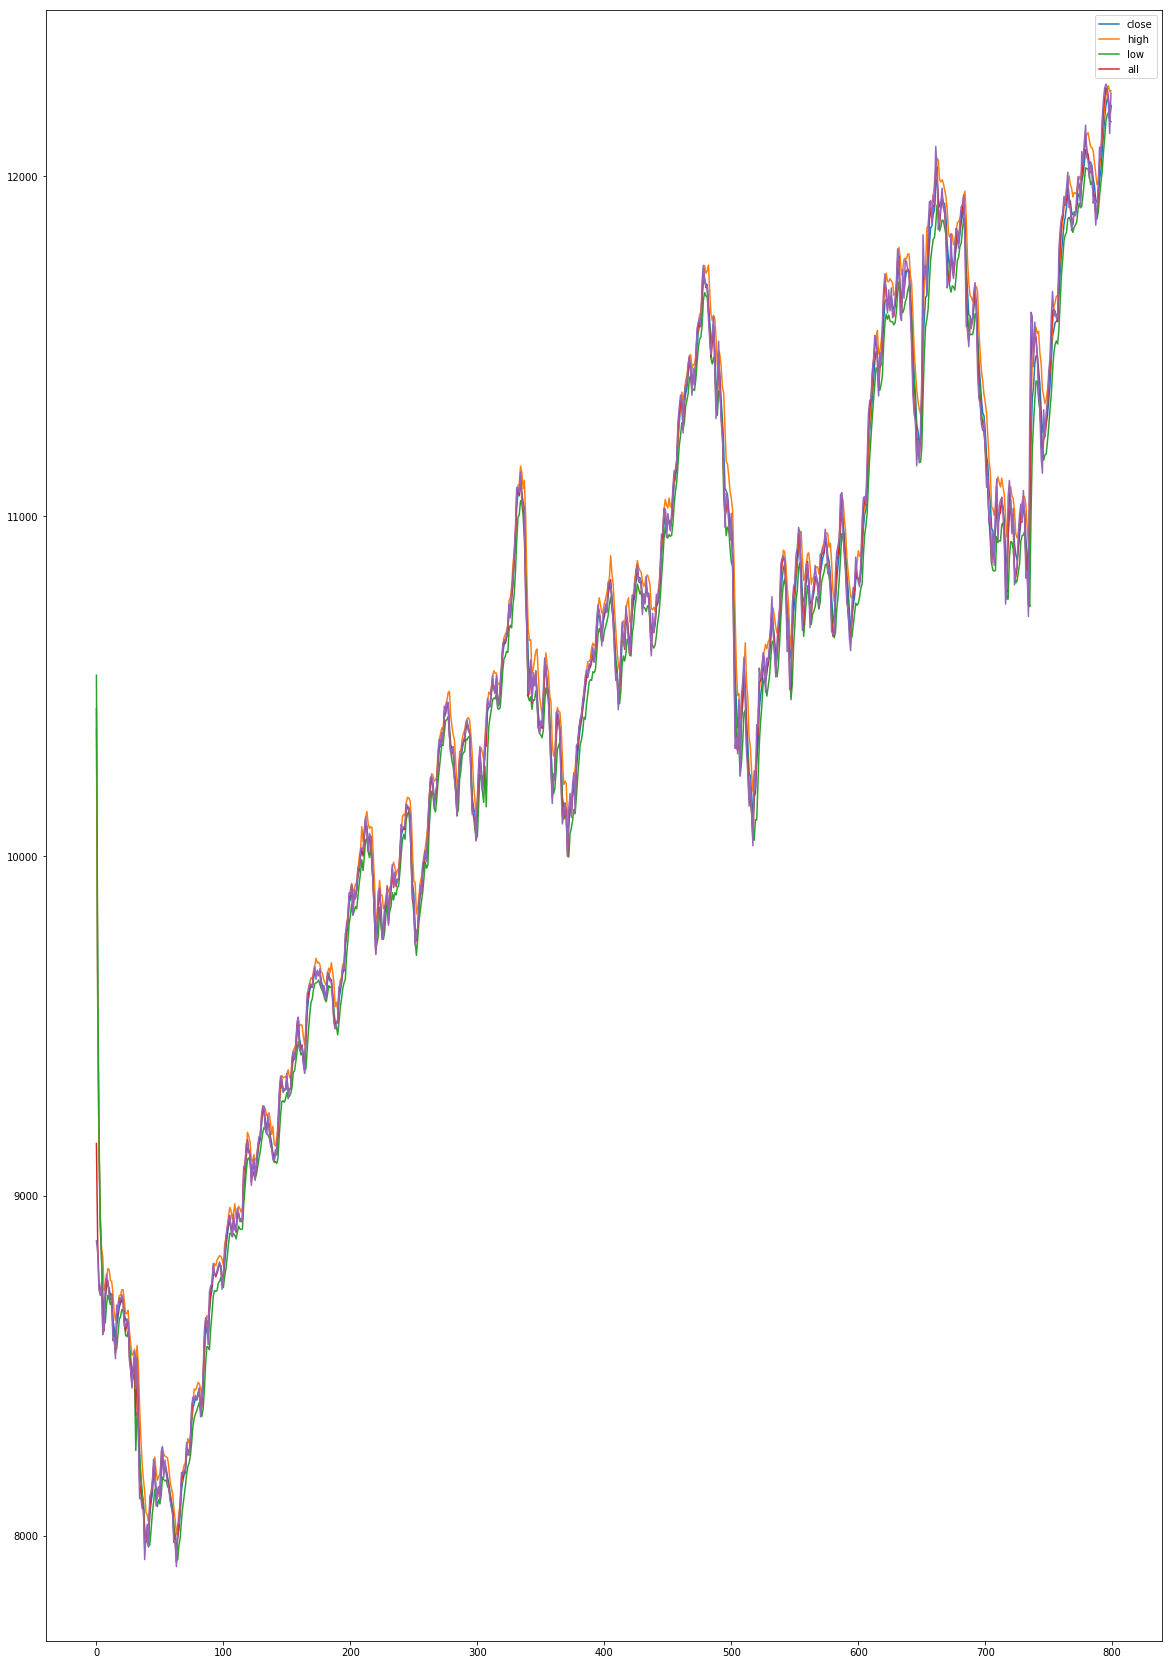

In [73]:
# plt.plot(prediction)
plt.figure(figsize=(20,30))
plt.plot(prediction_c, label = "close")
plt.plot(prediction_h, label = "high")
plt.plot(prediction_l, label = "low")
plt.plot(prediction_all, label = "all")
plt.plot(list(nifty["Close"][176:]))
plt.legend()